## Global settings and imports

In [19]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Dict, List, Optional
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings
from utils._python import write_submission_file, rank_predictions_by_score

from models_pytorch.model_config import hparams_nrms
from models_pytorch.nrms import NRMSModel

from transformers import AutoModel, AutoTokenizer
from models_pytorch.dataloader import NRMSDataLoader



# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version: 3.10.12
PyTorch version: 2.4.1+cu124
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU
Number of GPUs available: 1


## Prepare parameters

In [20]:
seed = 42
batch_size = 32

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

In [21]:
# Let's first check the data structure
behaviors_path = Path("ebnerd_demo/train/behaviors.parquet")
df = pd.read_parquet(behaviors_path)
print("Behaviors columns:", df.columns)

Behaviors columns: Index(['impression_id', 'article_id', 'impression_time', 'read_time',
       'scroll_percentage', 'device_type', 'article_ids_inview',
       'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode',
       'age', 'is_subscriber', 'session_id', 'next_read_time',
       'next_scroll_percentage'],
      dtype='object')


In [22]:
# Debug print for history file structure
history_df = pd.read_parquet("ebnerd_demo/train/history.parquet")
print("\nHistory file columns:", history_df.columns)
print("\nFirst row of history:", history_df.iloc[0])


History file columns: Index(['user_id', 'impression_time_fixed', 'scroll_percentage_fixed',
       'article_id_fixed', 'read_time_fixed'],
      dtype='object')

First row of history: user_id                                                                13538
impression_time_fixed      [2023-04-27T10:17:43.000000, 2023-04-27T10:18:...
scroll_percentage_fixed    [100.0, 35.0, 100.0, 24.0, 100.0, 23.0, 100.0,...
article_id_fixed           [9738663, 9738569, 9738663, 9738490, 9738663, ...
read_time_fixed            [17.0, 12.0, 4.0, 5.0, 4.0, 9.0, 5.0, 46.0, 11...
Name: 0, dtype: object


## Download and load data

In [23]:
PATH = Path("./ebnerd_demo")  # Base path for your data directory
print(PATH)


ebnerd_demo


In [24]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
]
HISTORY_SIZE = 10
FRACTION = 0.01

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,labels
u32,list[i32],list[i64],list[i64],u32,list[i8]
374239,"[9765438, 9766627, … 9770333]","[9774789, 9774764, … 9771992]",[9774542],121516709,"[0, 0, … 0]"
638393,"[9769404, 9769366, … 9769888]","[9772659, 9773673, … 9773673]",[9772659],139303896,"[1, 0, … 0]"


In [25]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3000022,"""Hanks beskyldt for mishandling""","""Tom Hanks har angiveligt misha…",2023-06-29 06:20:32,false,"""Tom Hanks skulle angiveligt ha…",2006-09-20 09:24:18,[3518381],"""article_default""","""https://ekstrabladet.dk/underh…","[""David Gardner""]","[""PER""]","[""Kriminalitet"", ""Kendt"", … ""Litteratur""]",414,[432],"""underholdning""",null,null,null,0.9911,"""Negative"""
3000063,"""Bostrups aske spredt i Furesøe…","""Studieværten blev mindet med g…",2023-06-29 06:20:32,false,"""Strålende sensommersol. Jazzed…",2006-09-24 07:45:30,"[3170935, 3170939]","""article_default""","""https://ekstrabladet.dk/nyhede…",[],[],"[""Kendt"", ""Underholdning"", … ""Personlig begivenhed""]",118,[133],"""nyheder""",null,null,null,0.5155,"""Neutral"""


In [26]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

/home/miki/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Init dataloaders



In [27]:


train_dataset = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=2*batch_size,
)
val_dataset = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=batch_size,
)

In [28]:
for idx in range(5):
    sample = train_dataset[idx]
    print(f"Sample {idx}:")
    print(f"his_input_title shape: {sample[0][0].shape}")
    print(f"pred_input_title shape: {sample[0][1].shape}")
    print(f"Targets shape: {sample[1].shape} , {sample[1].dtype} {sample[1].sum()}")


Sample 0:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30])
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 1:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30])
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 2:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30])
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 3:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30])
Targets shape: torch.Size([5]) , torch.float32 1.0
Sample 4:
his_input_title shape: torch.Size([10, 30])
pred_input_title shape: torch.Size([5, 30])
Targets shape: torch.Size([5]) , torch.float32 1.0


In [29]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    try:
        his_input_titles = [item[0][0] for item in batch]  # List of tensors
        pred_input_titles = [item[0][1] for item in batch]
        batch_ys = [item[1] for item in batch]

        # Check for empty sequences
        for idx, seq in enumerate(his_input_titles):
            if seq.size(0) == 0:
                print(f"Empty his_input_title at batch index {idx}")
        for idx, seq in enumerate(pred_input_titles):
            if seq.size(0) == 0:
                print(f"Empty pred_input_title at batch index {idx}")
        for idx, seq in enumerate(batch_ys):
            if seq.size(0) == 0:
                print(f"Empty batch_y at batch index {idx}")

        # Remove empty sequences or handle them appropriately
        # For now, let's filter them out
        valid_indices = [i for i, seq in enumerate(his_input_titles) if seq.size(0) > 0 and pred_input_titles[i].size(0) > 0 and batch_ys[i].size(0) > 0]
        if not valid_indices:
            raise ValueError("All sequences in the batch are empty.")

        his_input_titles = [his_input_titles[i] for i in valid_indices]
        pred_input_titles = [pred_input_titles[i] for i in valid_indices]
        batch_ys = [batch_ys[i] for i in valid_indices]

        # Pad sequences
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=0)

        return (his_input_titles_padded, pred_input_titles_padded), batch_ys_padded
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise

In [30]:
# Wrap the dataset with DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

## Create hyper-parameters

In [31]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    his_input_title, pred_input_title = inputs
    print(f"Batch {batch_idx + 1}")
    print(f"his_input_title shape: {his_input_title.shape}, dtype: {his_input_title.dtype}")
    print(f"pred_input_title shape: {pred_input_title.shape}, dtype: {pred_input_title.dtype}")
    print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
    break

Batch 1
his_input_title shape: torch.Size([32, 10, 30]), dtype: torch.float32
pred_input_title shape: torch.Size([32, 5, 30]), dtype: torch.float32
Targets shape: torch.Size([32, 5]), dtype: torch.float32


## Train the NRMS model

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=2, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.verbose:
                print(f"Initial validation loss: {self.best_loss:.6f}")
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss decreased to {self.best_loss:.6f}. Resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
early_stopping = EarlyStopping(patience=2, verbose=True)
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)


# Initialize your model
# Ensure that NRMSModel is a PyTorch nn.Module

# CUDA checks
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = NRMSModel(
    hparams=hparams_nrms.__dict__,
    word2vec_embedding=word2vec_embedding,
    seed=seed,
    device=device
)
print(f"Model device: {next(model.parameters()).device}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda
Model device: cuda:0


In [33]:
# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
NUM_EPOCHS = 3  # Early stopping will handle actual stopping

train_losses = []
val_losses = []

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Debug print GPU memory
        if batch_idx % 10 == 0:
            print(f"\nGPU Memory Usage:")
            print(f"Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
            print(f"Cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")
        
        # Move to device
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)
        
        # Ensure exactly one positive label per sample
        positive_counts = (targets == 1).sum(dim=1)
        if not torch.all(positive_counts == 1):
            raise ValueError("Expected exactly one positive label per sample in targets.")

        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()

        # Forward pass
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        current_loss = loss.item()
        progress = (batch_idx + 1) / len(train_dataloader) * 100

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)

            positive_counts = (targets == 1).sum(dim=1)
            if not torch.all(positive_counts == 1):
                raise ValueError("Expected exactly one positive label per sample in targets.")

            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1]
            targets = targets.long()

            outputs = model(*inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check for improvement
    # model_checkpoint(model, avg_val_loss)
    # early_stopping(avg_val_loss)

    # if early_stopping.early_stop:
    #     print("Early stopping triggered. Stopping training.")
    #     break

# Close the TensorBoard writer
writer.close()



GPU Memory Usage:
Allocated: 2217.87 MB
Cached: 3702.00 MB


ValueError: Expected exactly one positive label per sample in targets.

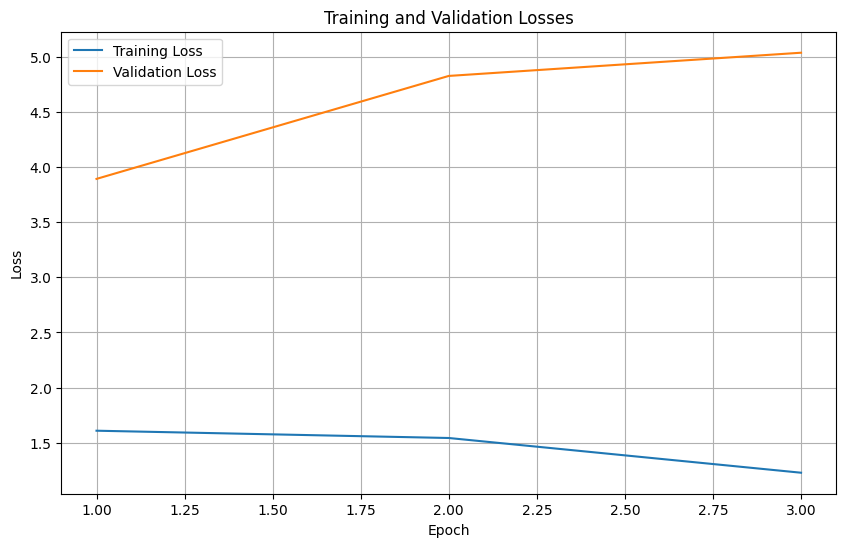


Training Summary:
Initial Training Loss: 1.6096
Final Training Loss: 1.2289
Best Training Loss: 1.2289

Initial Validation Loss: 3.8912
Final Validation Loss: 5.0344
Best Validation Loss: 3.8912


In [ ]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [56]:
with torch.no_grad():
    pred_validation = model.predict(val_dataloader)

# Add predictions to dataframe
df_validation = add_prediction_scores(df_validation, pred_validation).pipe(
    add_known_user_column, known_users=df_train[DEFAULT_USER_COL]
)

# Compute metrics
metrics = MetricEvaluator(
    labels=df_validation["labels"].to_list(),
    predictions=df_validation["scores"].to_list(),
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)


Metrics: {'auc': 0.5413917446191426, 'mrr': 0.33748190401623324, 'ndcg@5': 0.37965559641993263, 'ndcg@10': 0.4538256177524456}


## Output Prediction File

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb